In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


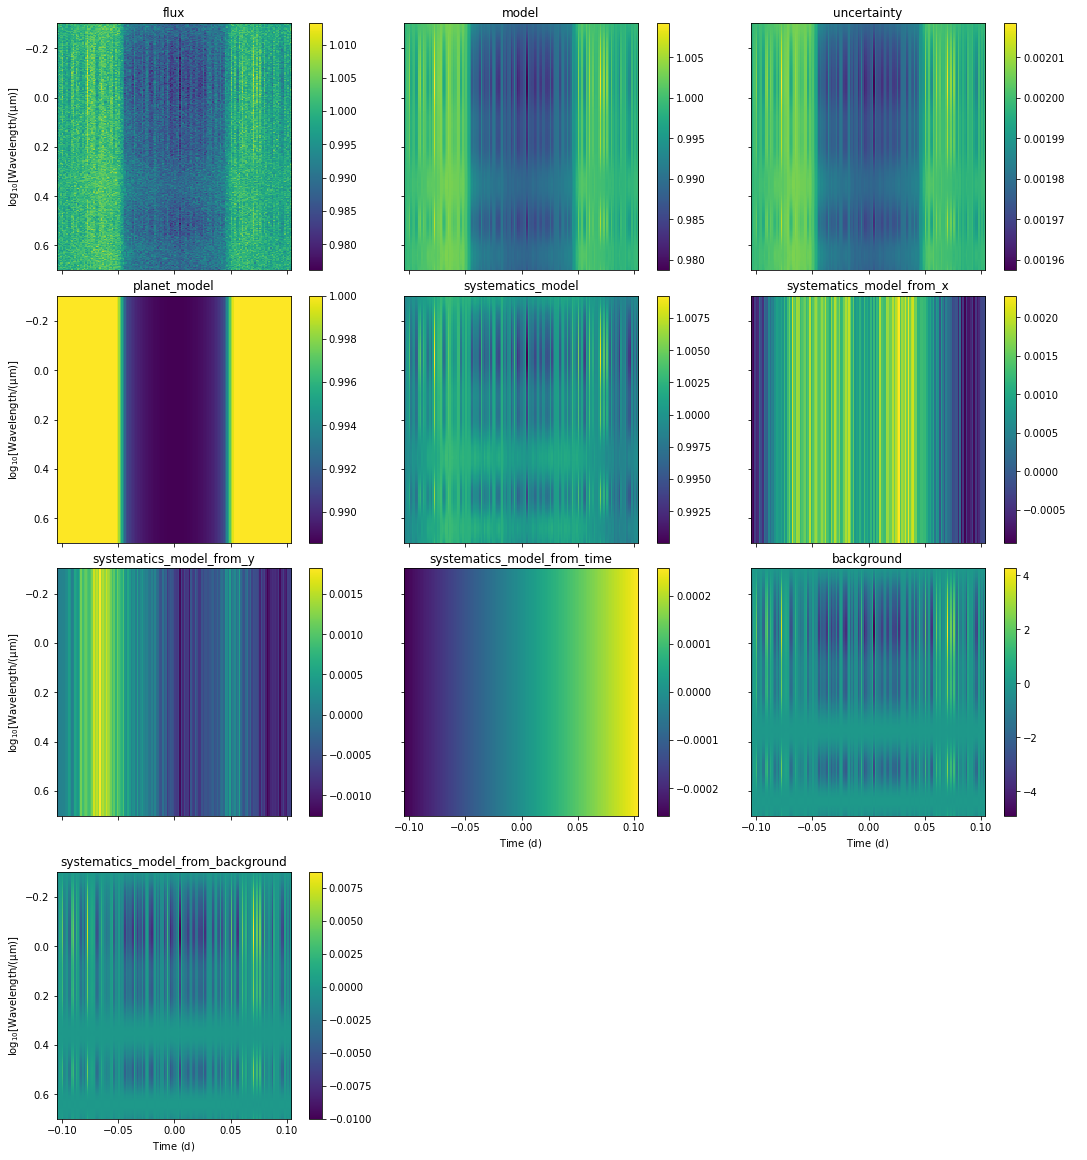

In [2]:
s = SimulatedRainbow().inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0 #Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

In [4]:
b_x.parameters

{'sx_p_0': <🧮 Fixed | 0.0 🧮>,
 'sx_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [5]:
b.parameters

{'stime_p_0': <🧮 Fixed | 1.0 🧮>,
 'stime_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [6]:
cm = t * (b + b_x + b_y + b_bkg)

In [7]:
cm

<chromatic combined model 🌈, models: stime(<chromatic polynomial model 🌈>) + sx(<chromatic polynomial model 🌈>) + sy(<chromatic polynomial model 🌈>) + sbkg(<chromatic polynomial model 🌈>) * transit(<chromatic transit model 🌈>)

In [8]:
cm.chromatic_models

{'stime': <chromatic polynomial model 🌈>,
 'sx': <chromatic polynomial model 🌈>,
 'sy': <chromatic polynomial model 🌈>,
 'sbkg': <chromatic polynomial model 🌈>,
 'transit': <chromatic transit model 🌈>}

In [9]:
cm.how_to_combine

['+', '+', '+', '*']

In [10]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 

In [11]:
cm.attach_data(s)
cm.choose_optimization_method('separate')
cm.setup_lightcurves()
cm.setup_likelihood()

100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]


In [12]:
print(cm.chromatic_models)
print()
print(cm.pymc3_model[2])

{'stime': <chromatic polynomial model 🌈>, 'sx': <chromatic polynomial model 🌈>, 'sy': <chromatic polynomial model 🌈>, 'sbkg': <chromatic polynomial model 🌈>, 'transit': <chromatic transit model 🌈>}

                            stime_p_1_w2 ~ Normal
                               sx_p_1_w2 ~ Normal
                               sy_p_1_w2 ~ Normal
                             sbkg_p_1_w2 ~ Normal
             transit_epoch_w2_interval__ ~ TransformedDistribution
    transit_impact_parameter_w2_impact__ ~ TransformedDistribution
    transit_stellar_radius_w2_interval__ ~ TransformedDistribution
      transit_stellar_mass_w2_interval__ ~ TransformedDistribution
transit_limb_darkening_w2_quadlimbdark__ ~ TransformedDistribution
                 transit_radius_ratio_w2 ~ Normal
                        transit_epoch_w2 ~ Uniform
             transit_impact_parameter_w2 ~ ImpactParameter
               transit_stellar_radius_w2 ~ Uniform
                 transit_stellar_mass_w2 ~ Uniform
    

In [13]:
## combine the models - old method!
# cm = CombinedModel()
# cm.initialize_empty_model()
# cm.attach_models({'transit':t,'time':b,'x':b_x,'y':b_y,'background':b_bkg}) #'transit':t,
# cm.attach_data(s)
# cm.setup_lightcurves()
# cm.setup_likelihood()
# print(cm.chromatic_models)
# print(cm.pymc3_model)


🌈 Warning: invalid value encountered in log

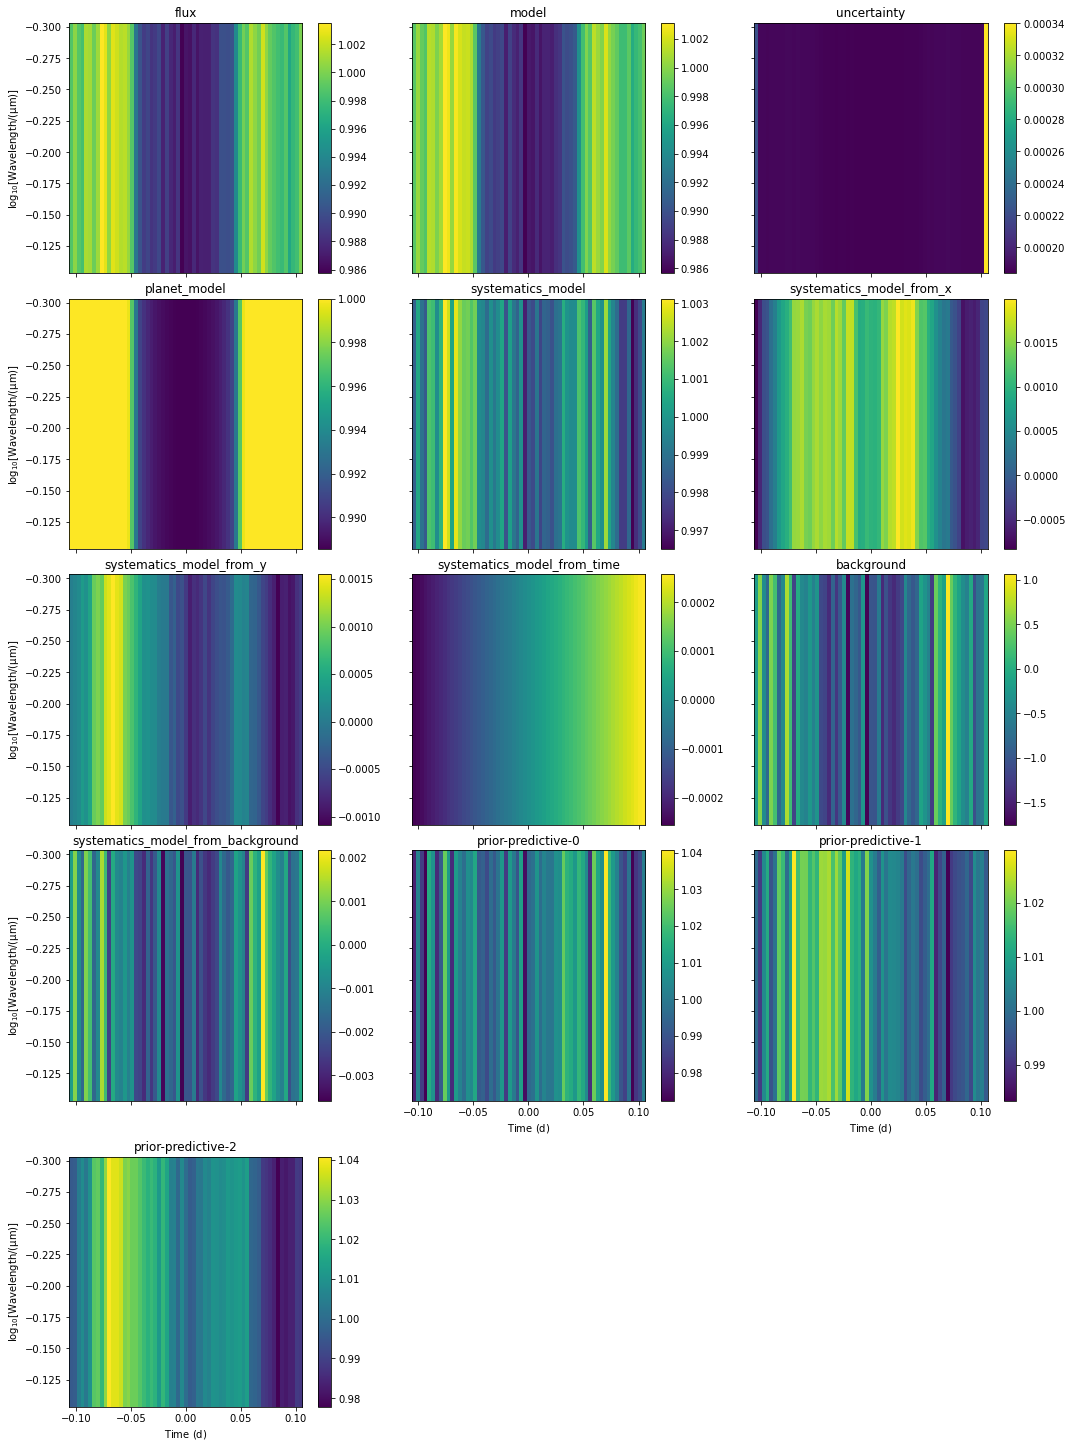

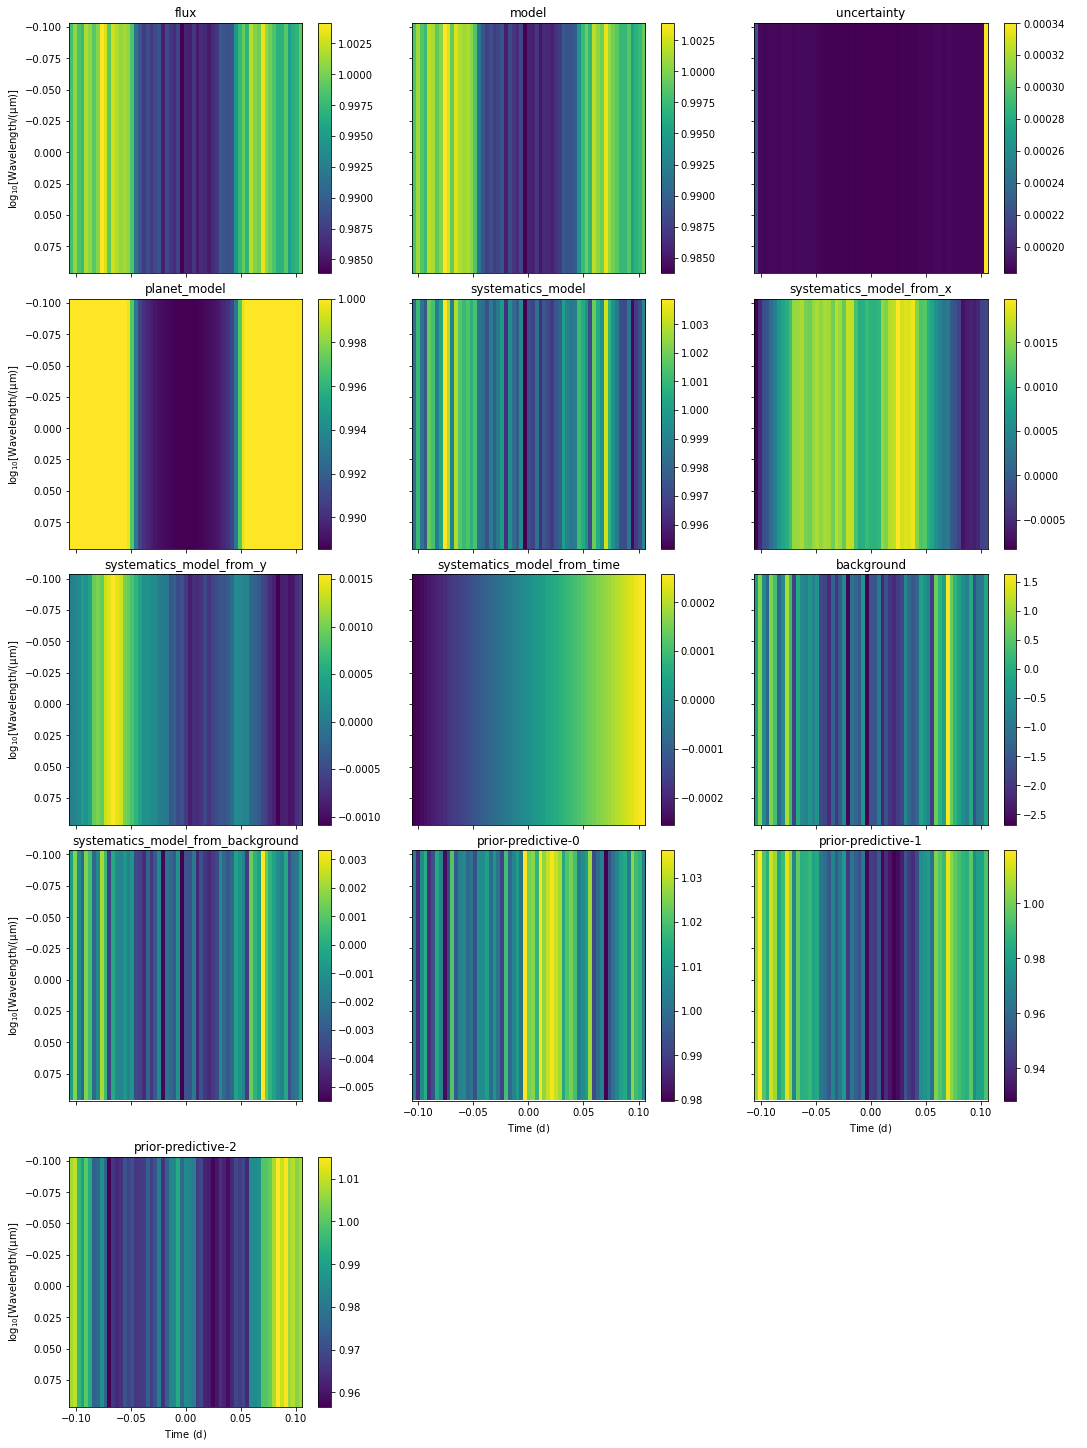

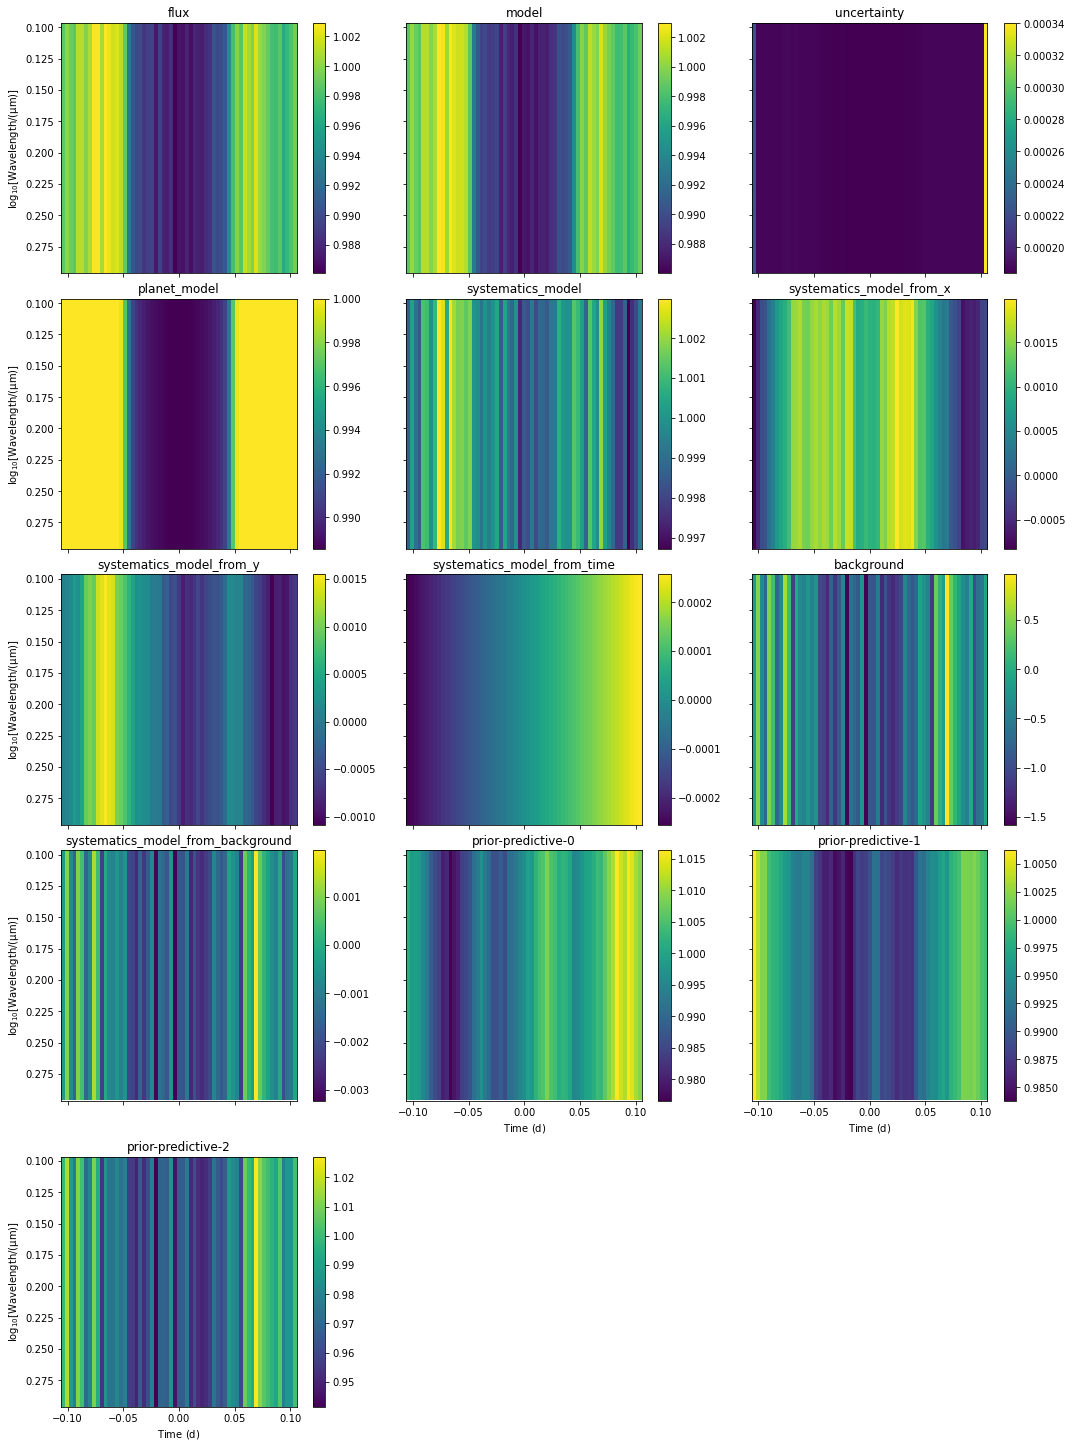

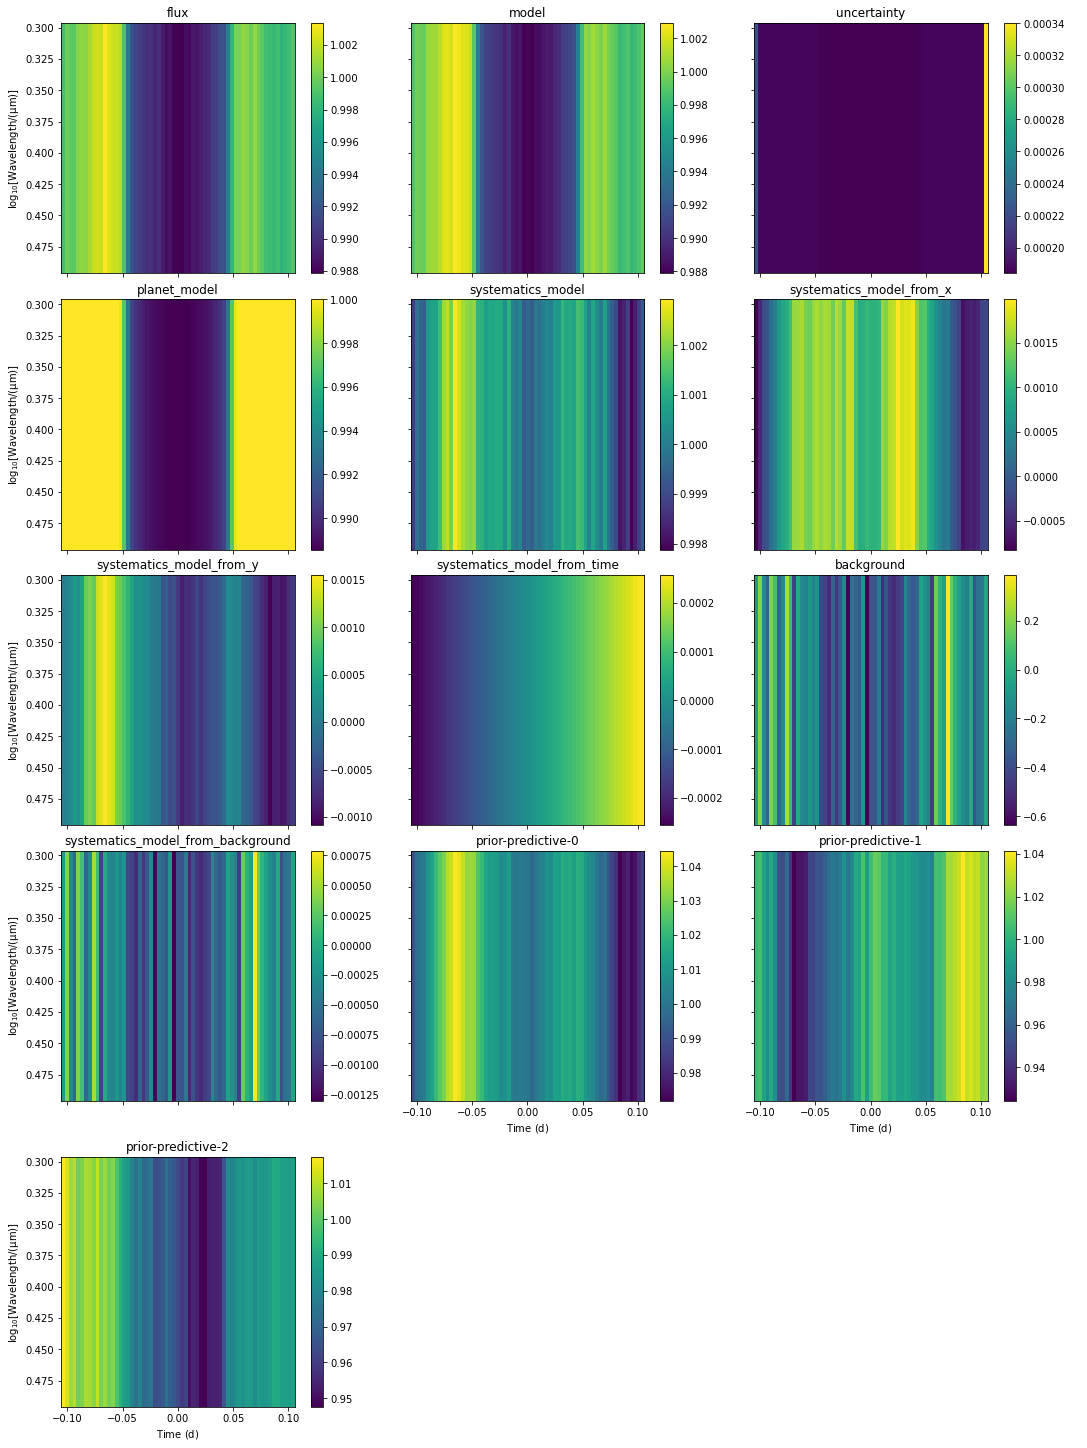

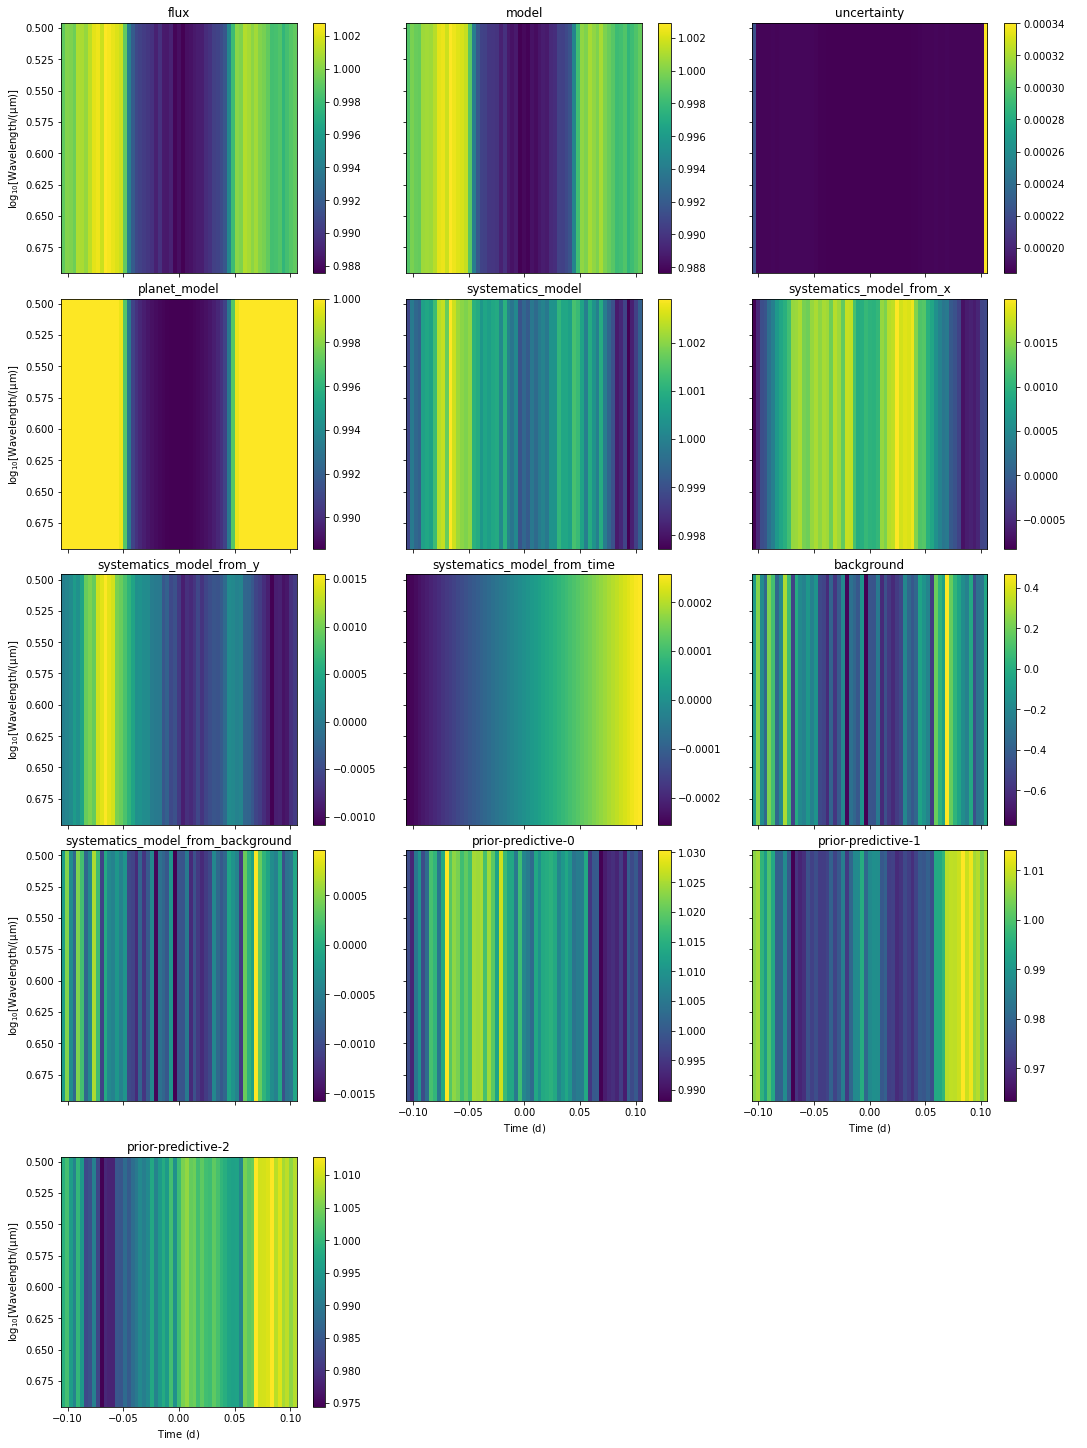

In [14]:
cm.plot_priors()

In [15]:
opt = cm.optimize()
cm.sample(start=opt, tune=2000, draws=2000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [transit_radius_ratio_w0, transit_limb_darkening_w0, transit_stellar_mass_w0, transit_stellar_radius_w0, transit_impact_parameter_w0, transit_epoch_w0, sbkg_p_1_w0, sy_p_1_w0, sx_p_1_w0, stime_p_1_w0]


message: Desired error not necessarily achieved due to precision loss.
logp: -10682.914594879669 -> -853.8293617081154
optimizing logp for variables: [transit_radius_ratio_w1, transit_limb_darkening_w1, transit_stellar_mass_w1, transit_stellar_radius_w1, transit_impact_parameter_w1, transit_epoch_w1, sbkg_p_1_w1, sy_p_1_w1, sx_p_1_w1, stime_p_1_w1]


message: Desired error not necessarily achieved due to precision loss.
logp: -15093.302980235332 -> -768.8356173895523
optimizing logp for variables: [transit_radius_ratio_w2, transit_limb_darkening_w2, transit_stellar_mass_w2, transit_stellar_radius_w2, transit_impact_parameter_w2, transit_epoch_w2, sbkg_p_1_w2, sy_p_1_w2, sx_p_1_w2, stime_p_1_w2]


message: Desired error not necessarily achieved due to precision loss.
logp: -9812.499493274023 -> -790.7769213320249
optimizing logp for variables: [transit_radius_ratio_w3, transit_limb_darkening_w3, transit_stellar_mass_w3, transit_stellar_radius_w3, transit_impact_parameter_w3, transit_epoch_w3, sbkg_p_1_w3, sy_p_1_w3, sx_p_1_w3, stime_p_1_w3]


message: Desired error not necessarily achieved due to precision loss.
logp: -6754.787429454432 -> -866.3875779566555
optimizing logp for variables: [transit_radius_ratio_w4, transit_limb_darkening_w4, transit_stellar_mass_w4, transit_stellar_radius_w4, transit_impact_parameter_w4, transit_epoch_w4, sbkg_p_1_w4, sy_p_1_w4, sx_p_1_w4, stime_p_1_w4]


message: Desired error not necessarily achieved due to precision loss.
logp: -6922.554806142884 -> -2292.2816630134553



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w0, transit_limb_darkening_w0, transit_stellar_mass_w0, transit_stellar_radius_w0, transit_impact_parameter_w0, transit_epoch_w0, sbkg_p_1_w0, sy_p_1_w0, sx_p_1_w0, stime_p_1_w0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w1, transit_limb_darkening_w1, transit_stellar_mass_w1, transit_stellar_radius_w1, transit_impact_parameter_w1, transit_epoch_w1, sbkg_p_1_w1, sy_p_1_w1, sx_p_1_w1, stime_p_1_w1]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w2, transit_limb_darkening_w2, transit_stellar_mass_w2, transit_stellar_radius_w2, transit_impact_parameter_w2, transit_epoch_w2, sbkg_p_1_w2, sy_p_1_w2, sx_p_1_w2, stime_p_1_w2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w3, transit_limb_darkening_w3, transit_stellar_mass_w3, transit_stellar_radius_w3, transit_impact_parameter_w3, transit_epoch_w3, sbkg_p_1_w3, sy_p_1_w3, sx_p_1_w3, stime_p_1_w3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 144 seconds.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6150549207232152, but should be close to 0.9. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8219930797172218, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w0, transit_limb_darkening_w0, transit_stellar_mass_w0, transit_stellar_radius_w0, transit_impact_parameter_w0, transit_epoch_w0, sbkg_p_1_w0, sy_p_1_w0, sx_p_1_w0, stime_p_1_w0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w1, transit_limb_darkening_w1, transit_stellar_mass_w1, transit_stellar_radius_w1, transit_impact_parameter_w1, transit_epoch_w1, sbkg_p_1_w1, sy_p_1_w1, sx_p_1_w1, stime_p_1_w1]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w2, transit_limb_darkening_w2, transit_stellar_mass_w2, transit_stellar_radius_w2, transit_impact_parameter_w2, transit_epoch_w2, sbkg_p_1_w2, sy_p_1_w2, sx_p_1_w2, stime_p_1_w2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.801081346341693, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w3, transit_limb_darkening_w3, transit_stellar_mass_w3, transit_stellar_radius_w3, transit_impact_parameter_w3, transit_epoch_w3, sbkg_p_1_w3, sy_p_1_w3, sx_p_1_w3, stime_p_1_w3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w4, transit_limb_darkening_w4, transit_stellar_mass_w4, transit_stellar_radius_w4, transit_impact_parameter_w4, transit_epoch_w4, sbkg_p_1_w4, sy_p_1_w4, sx_p_1_w4, stime_p_1_w4]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.


[                                  mean        sd    hdi_3%   hdi_97%  \
stime_p_1_w0                  0.033347  0.000684  0.032018  0.034558   
sx_p_1_w0                     0.003262  0.000035  0.003195  0.003328   
sy_p_1_w0                     0.004992  0.000046  0.004906  0.005079   
sbkg_p_1_w0                   0.002380  0.000051  0.002288  0.002480   
transit_radius_ratio_w0       0.056976  0.000820  0.055414  0.058546   
transit_epoch_w0             -0.019108  0.000155 -0.019398 -0.018819   
transit_impact_parameter_w0   0.370003  0.068840  0.245916  0.500773   
transit_stellar_radius_w0     0.819066  0.017307  0.800007  0.852235   
transit_stellar_mass_w0       1.130213  0.062651  1.011686  1.199994   
transit_limb_darkening_w0[0]  0.228414  0.159890  0.000403  0.512478   
transit_limb_darkening_w0[1]  0.428278  0.252719 -0.045333  0.869454   

                                 mcse_mean       mcse_sd     ess_bulk  \
stime_p_1_w0                  9.600000e-06  6.800000e-06  512


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

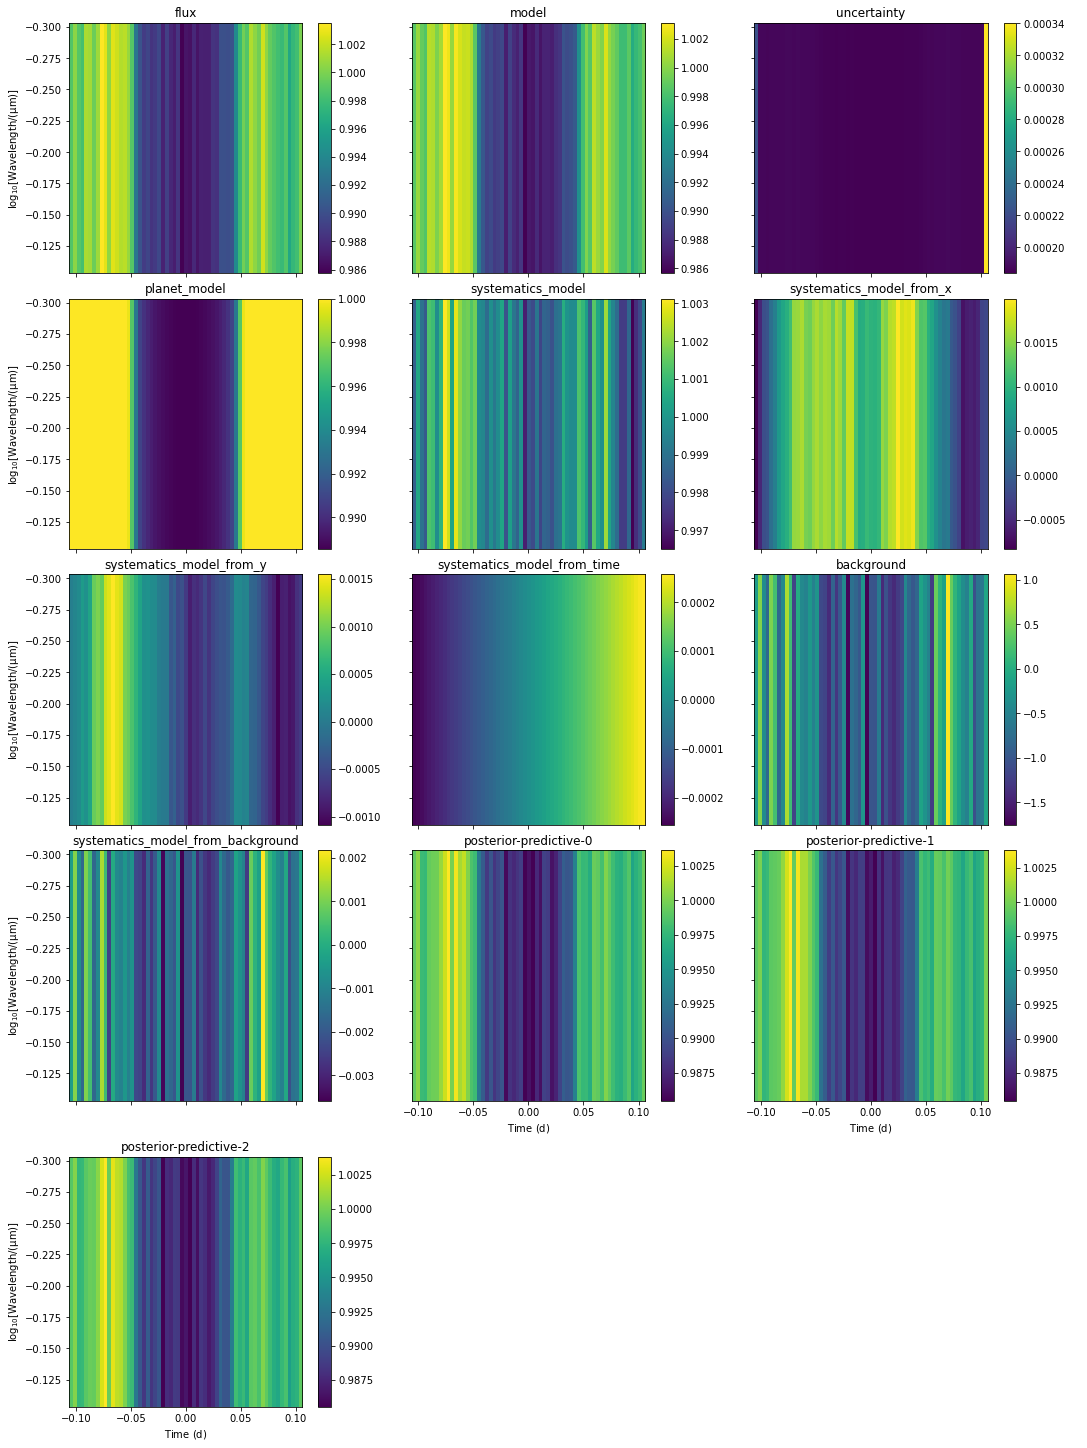

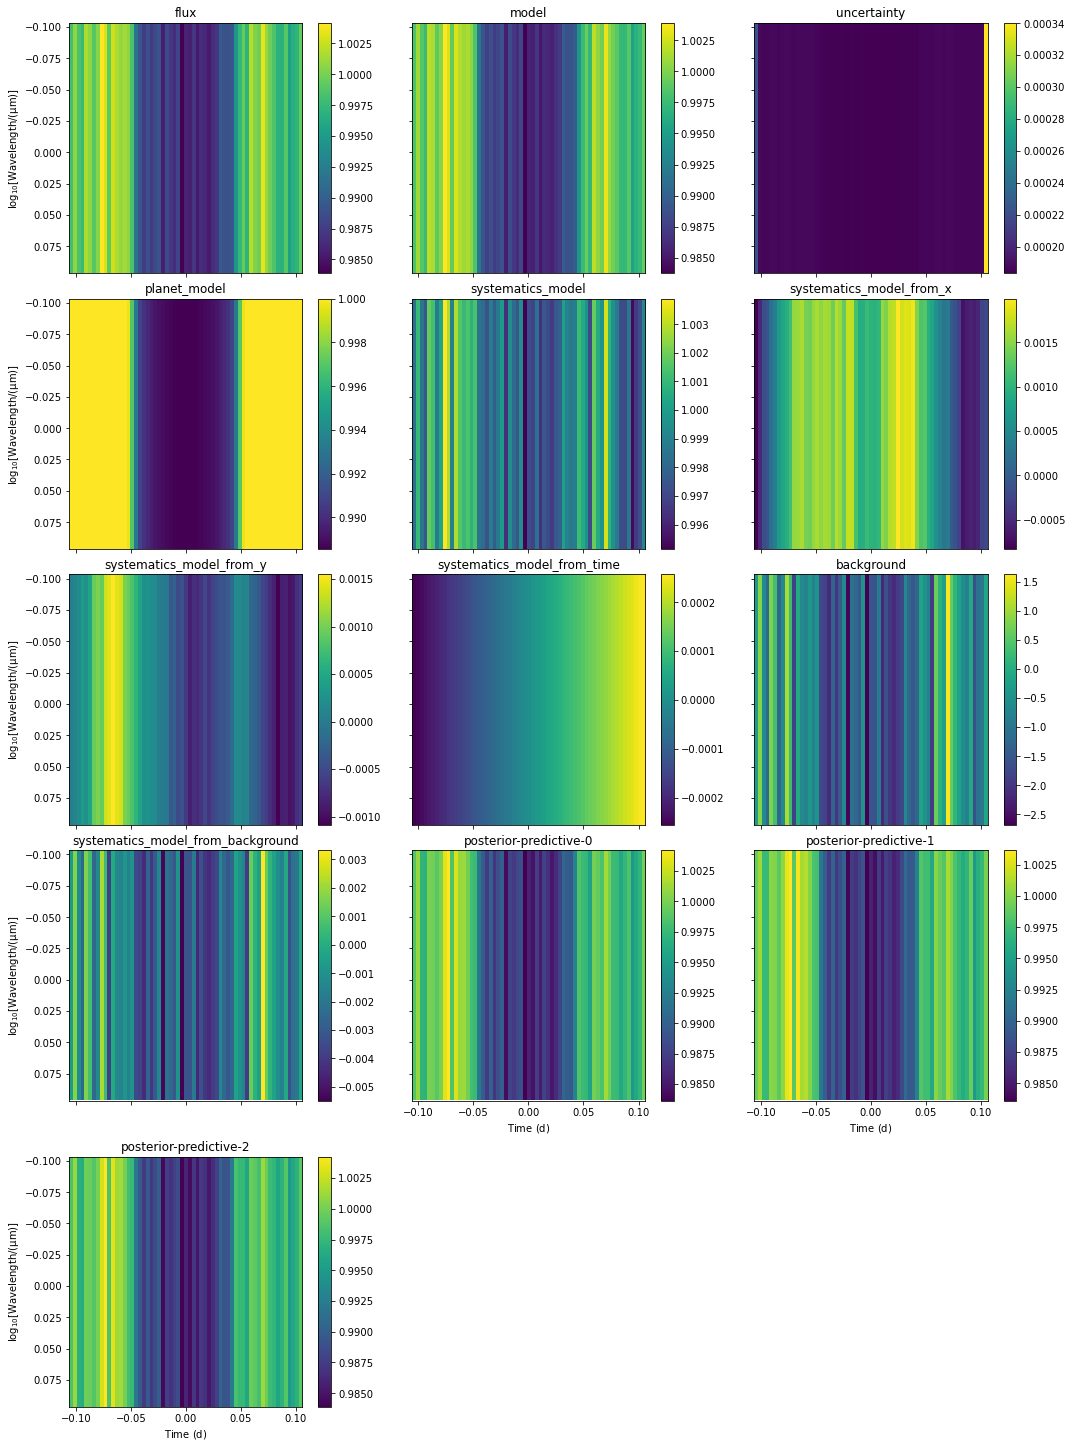

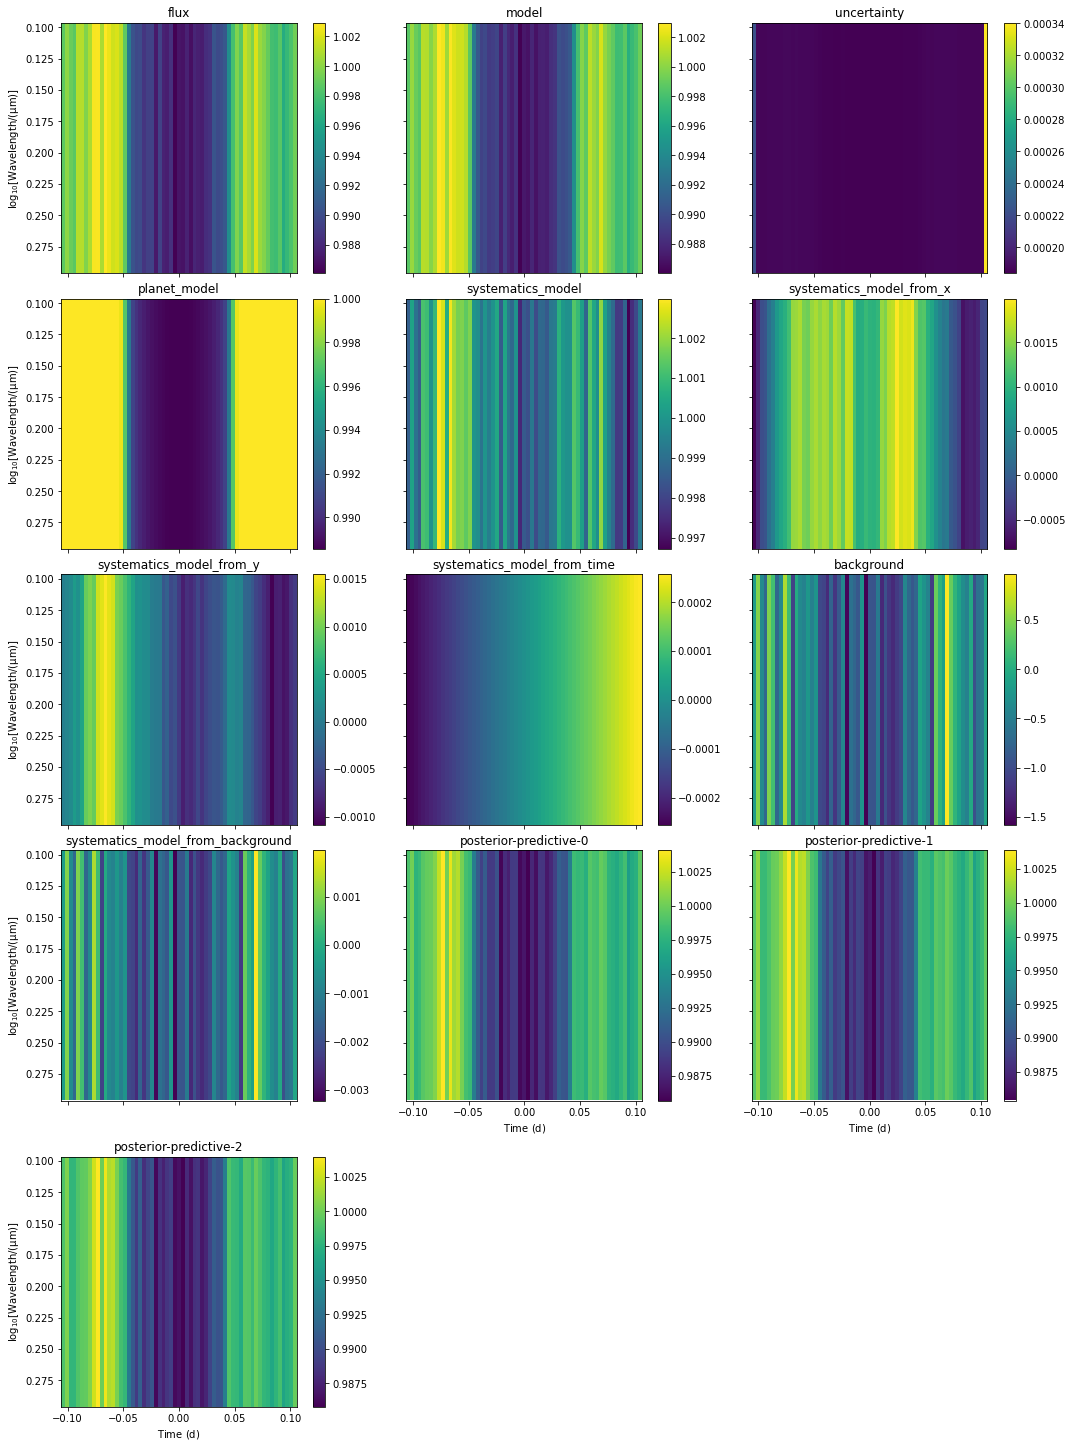

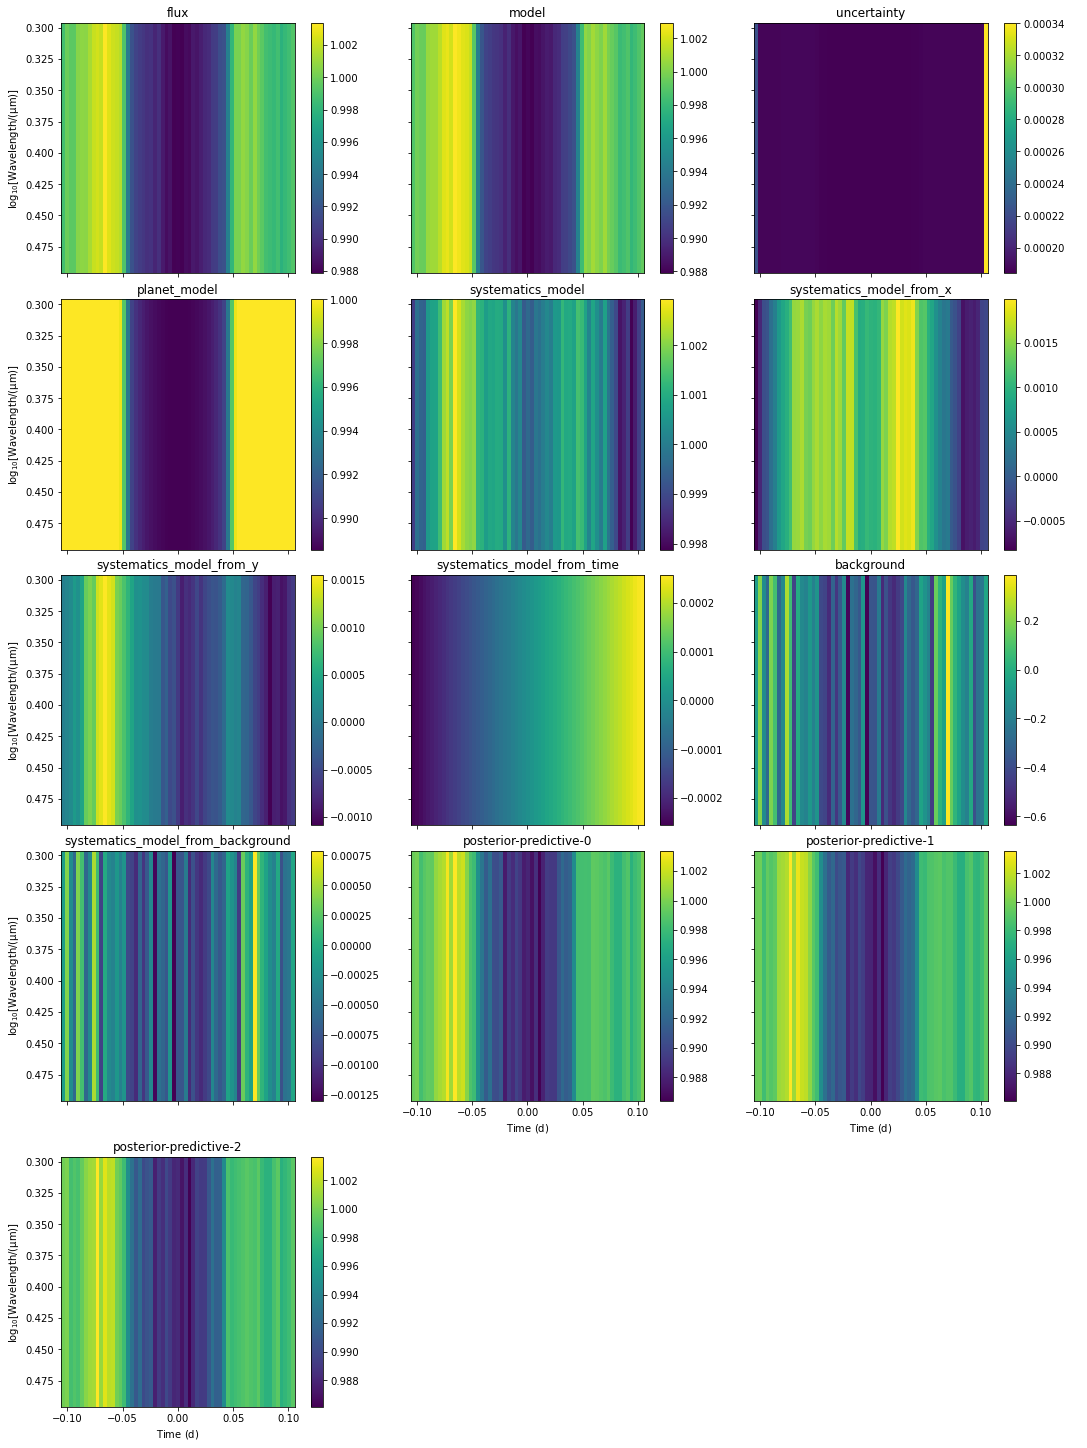

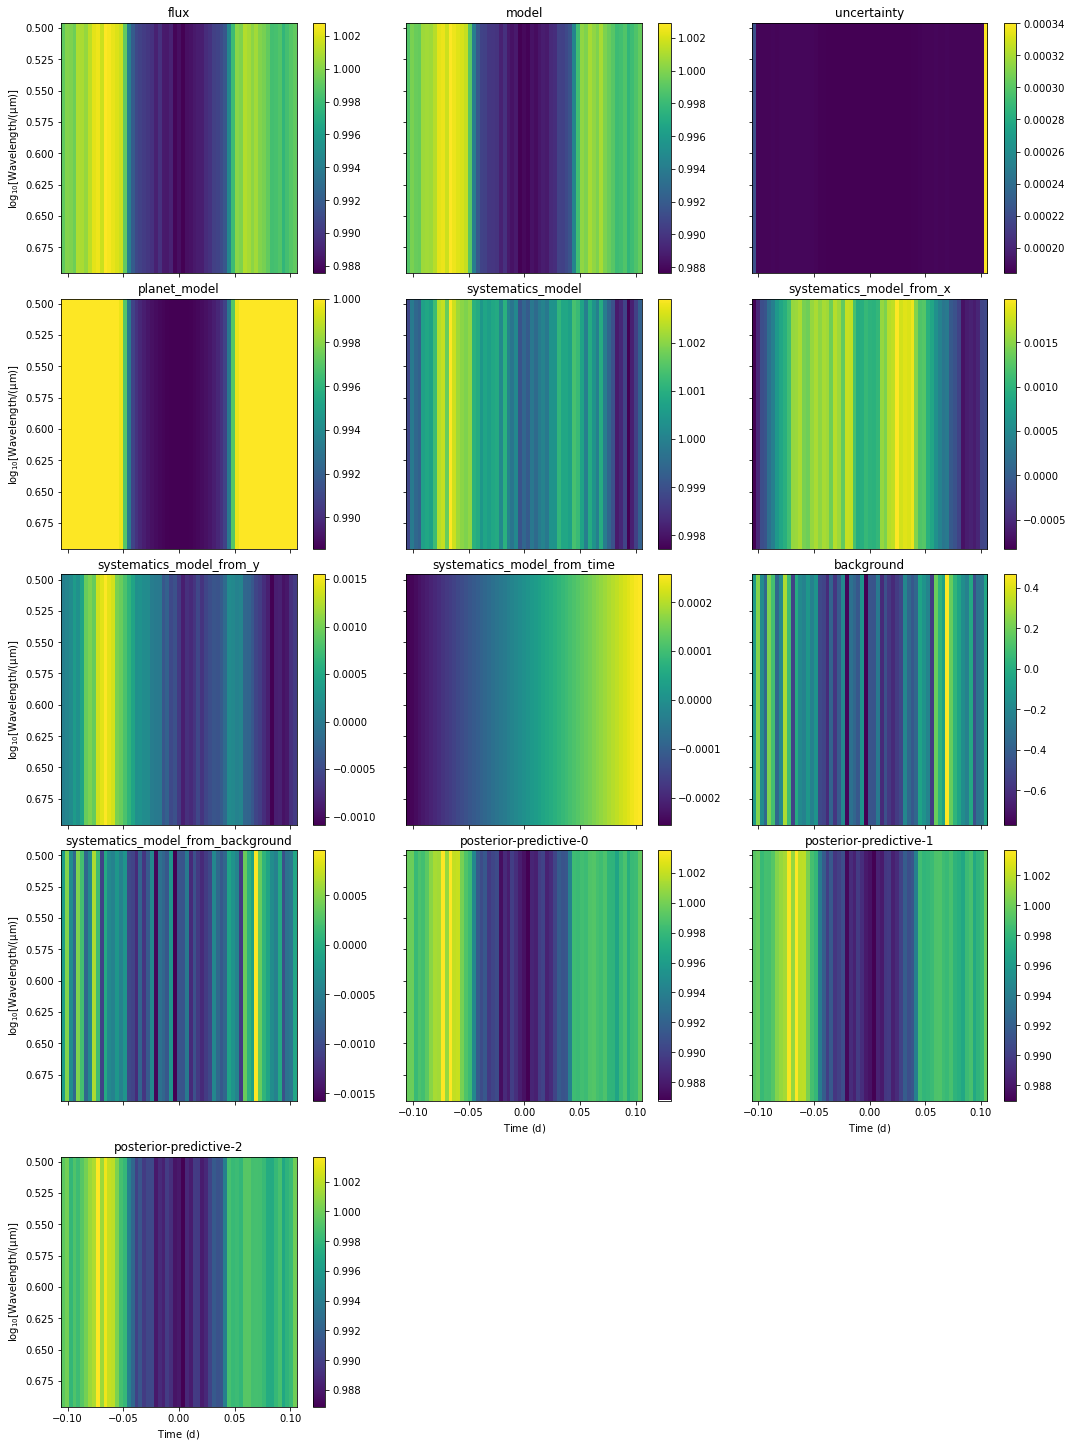

In [16]:
cm.plot_posteriors()

In [17]:
cm.summary['mean']

stime_p_1                    0.015984
sx_p_1                       0.001972
sy_p_1                      -0.003929
sbkg_p_1                    -0.002993
transit_radius_ratio_w0      0.100169
transit_radius_ratio_w1      0.099675
transit_radius_ratio_w2      0.100076
transit_radius_ratio_w3      0.100470
transit_radius_ratio_w4      0.099476
transit_radius_ratio_w5      0.100366
transit_radius_ratio_w6      0.099885
transit_radius_ratio_w7      0.099777
transit_radius_ratio_w8      0.100098
transit_radius_ratio_w9      0.100154
transit_epoch               -0.000066
transit_impact_parameter     0.142981
transit_stellar_radius       1.186423
transit_stellar_mass         0.828406
transit_limb_darkening[0]    0.230494
transit_limb_darkening[1]    0.284732
Name: mean, dtype: float64

In [18]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = 0.0019722621547265348
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = -0.003940364996216514
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = 0.0009592103218861727
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.003004839309355917
   offset_background = 0
    sigma_background = 1


In [19]:
cm.data.fluxlike['test_planet_recovered-0'] = cm.data.fluxlike['posterior-predictive-0'] - cm.data.fluxlike['systematics_model']
cm.data.fluxlike['test_residuals-0'] = 1 + cm.data.fluxlike['posterior-predictive-0'] - cm.data.fluxlike['systematics_model'] - cm.data.fluxlike['planet_model']

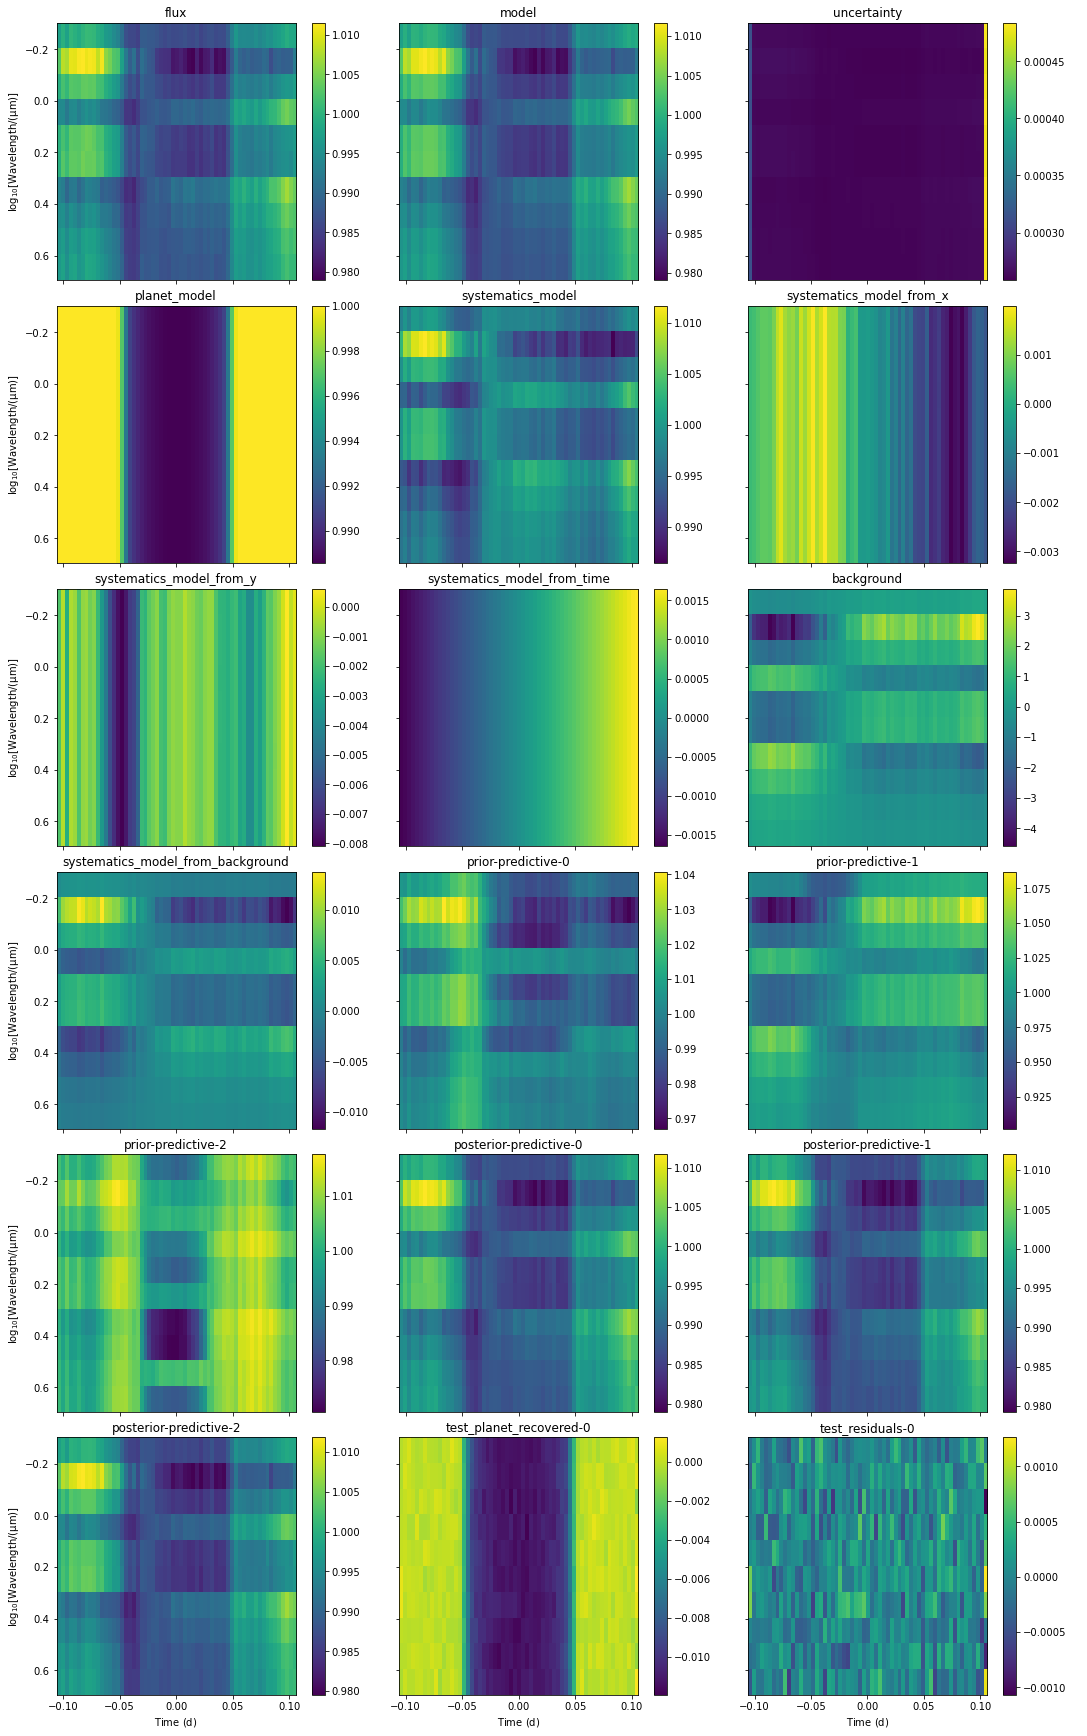

In [20]:
cm.data.imshow_quantities()

# Testing!

optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -52849.34418438209 -> 2223.3164028857623

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002051 -0.003559 -0.000538  -0.001925
recovered  0.002052 -0.003584 -0.000533  -0.001886 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -52849.34418438209 -> 2223.316402885762



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002051 -0.003559 -0.000538  -0.001925
recovered -0.002052  0.003583  0.000533  -0.001892 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -56100.03858355301 -> 2201.446194789077



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003154  0.000190  0.004020   0.027577
recovered -0.003148  0.000211  0.004041   0.027611 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -56100.03858355301 -> 2201.4461947890773



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003154  0.000190  0.004020   0.027577
recovered  0.003148 -0.000211 -0.004041   0.027609 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -36621.243797121584 -> 2222.179626428143



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.001144 -0.002010  0.001334   0.011351
recovered -0.001136 -0.002014  0.001333   0.011186 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -36621.243797121584 -> 2222.179626428143



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.001144 -0.002010  0.001334   0.011351
recovered  0.001136  0.002014 -0.001333   0.011190 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -8560.56691610655 -> 2220.88993939168



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.

KeyboardInterrupt



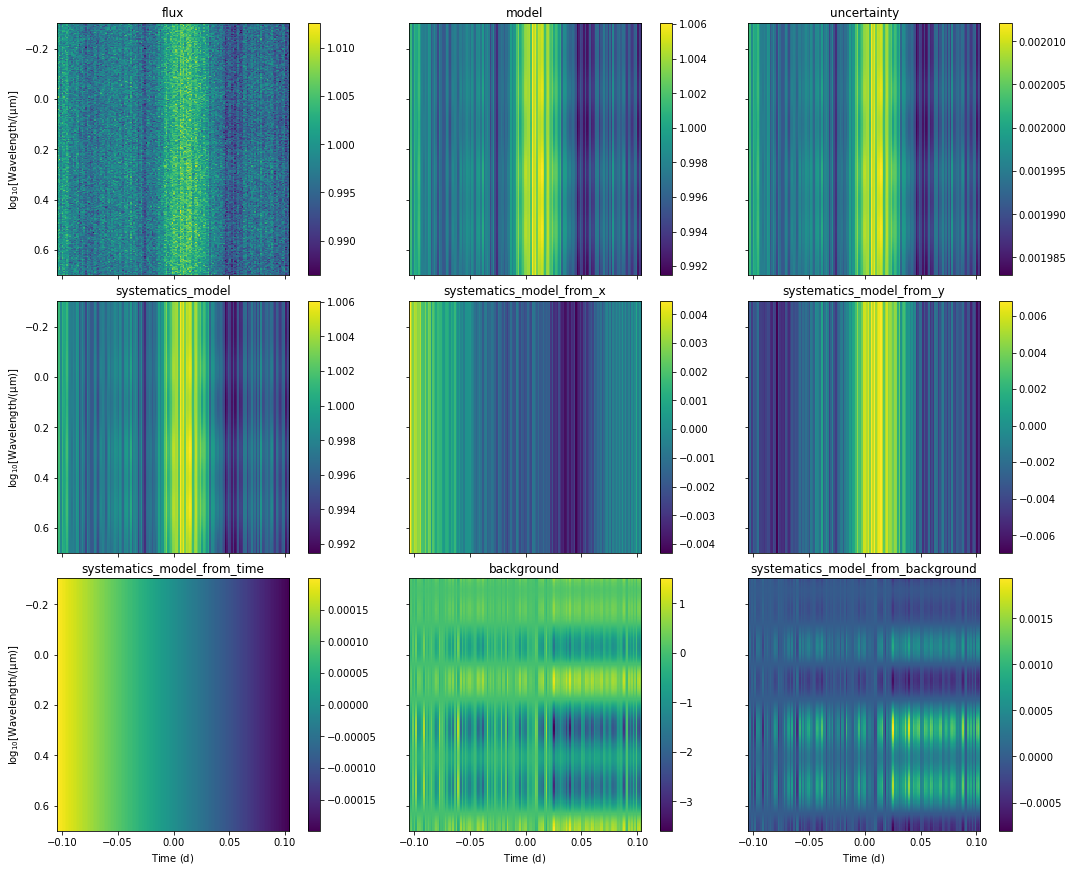

In [ ]:
for i in range(10):
    # create simulated rainbow + noise
    s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
    s.imshow_quantities();
    s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)
    
    cm = b + b_x + b_y + b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
#     print(cm.chromatic_models)
#     print(cm.pymc3_model)
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")
    
    cm = b - b_x - b_y - b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")

In [11]:
a = {'bla':30,'new':2}
b = {'bla':40}

In [12]:
subtract_dicts(a,b)

{'bla': 10, 'new': 2}

In [21]:
c = {**b,**a}
c

{'bla': 30, 'new': 2}

In [22]:
for key, value in c.items():
    if key in a and key in b:
        c[key] = value - b[key]

In [23]:
c

{'bla': -10, 'new': 2}